In [1]:
pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 5.3 MB/s 


In [2]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.callbacks import EarlyStopping

# Data Prep

loading the data

In [3]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()
node_subjects.value_counts().to_frame()

subject
Neural_Networks             818
Probabilistic_Methods       426
Genetic_Algorithms          418
Theory                      351
Case_Based                  298
Reinforcement_Learning      217
Rule_Learning               180

splitting the data : 140 nodes for training, 500 for validation and 2068 for testing

In [4]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

One hot encoding for node subjects

In [5]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

# Creating GCN layers

generator converts the core graph structure and node features into a format that can be fed into the Keras model for training or prediction
GCN is a full batch model
generator uses normalized graph laplacian matrix to capture graph structure (generator is only an encoder)

In [6]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


producing the model inputs

In [ ]:
#matching nodes and actual labels
train_gen = generator.flow(train_subjects.index, train_targets)

specifying the machine learning model: GCN with 2 hidden layers (16 units each)
Relu for activation function
dropout rate 50%


In [ ]:
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5)

input and output tensors

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

Predictions of each node’s class/subject will be computed from x_out (tensor that holds a 16-dim vector for nodes requested in traing/prediction) using an additional dense layer (with one unit per class) with softmax activation. softmax ensures that the final outputs for each input node will be a vector of probabilities( all values between 0 and 1, vector sum is 1). Predicted class is the element with the highest value.

In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

# Training and results

creating the Keras model
(to compute/predict 16 dim node embedding vecors, we can swap predictions to x_out and use dim reduction for visualizing)


In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

generator for validation and test set

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)
test_gen = generator.flow(test_subjects.index, test_targets)

stop training when validation accuracy stops improving

In [ ]:
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

training the model

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 4s - loss: 1.9552 - acc: 0.1500 - val_loss: 1.9198 - val_acc: 0.3120 - 4s/epoch - 4s/step
Epoch 2/200
1/1 - 0s - loss: 1.9138 - acc: 0.3000 - val_loss: 1.8867 - val_acc: 0.3160 - 277ms/epoch - 277ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8705 - acc: 0.3357 - val_loss: 1.8367 - val_acc: 0.3460 - 254ms/epoch - 254ms/step
Epoch 4/200
1/1 - 0s - loss: 1.8082 - acc: 0.3429 - val_loss: 1.7769 - val_acc: 0.3580 - 243ms/epoch - 243ms/step
Epoch 5/200
1/1 - 0s - loss: 1.7335 - acc: 0.3429 - val_loss: 1.7142 - val_acc: 0.3640 - 237ms/epoch - 237ms/step
Epoch 6/200
1/1 - 0s - loss: 1.6457 - acc: 0.3643 - val_loss: 1.6472 - val_acc: 0.3720 - 258ms/epoch - 258ms/step
Epoch 7/200
1/1 - 0s - loss: 1.5668 - acc: 0.3857 - val_loss: 1.5756 - val_acc: 0.3940 - 305ms/epoch - 305ms/step
Epoch 8/200
1/1 - 0s - loss: 1.4416 - acc: 0.4571 - val_loss: 1.5064 - val_acc: 0.4140 - 334ms/epoch - 334ms/step
Epoch 9/200
1/1 - 0s - loss: 1.3860 - acc: 0.4429 - val_loss: 1.4388 - val_acc: 0.4720 - 419ms

loss function behavior 

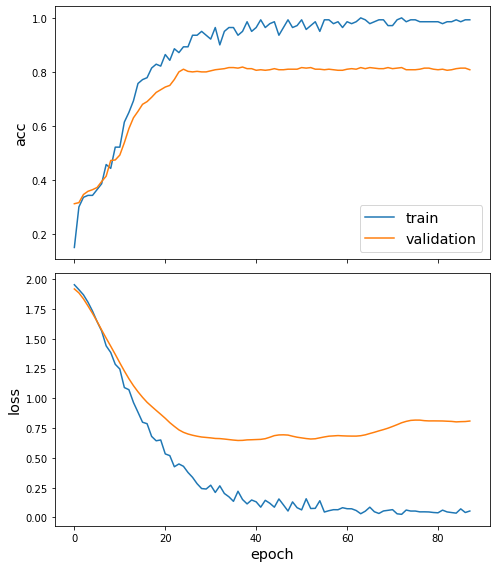

In [ ]:
sg.utils.plot_history(history)

# Testing

test data generator

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

metric values for trained model

In [ ]:
test_metrics = model.evaluate(test_gen)

1/1 [==============================] - 0s 115ms/step - loss: 0.7350 - acc: 0.8075


# making predictions 

predicting all classes without knowing the node subjects

In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

inverse transform from one-hot encoding to actual subjects

In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

Predicted                    True
31336           Neural_Networks         Neural_Networks
1061127           Rule_Learning           Rule_Learning
1106406  Reinforcement_Learning  Reinforcement_Learning
13195    Reinforcement_Learning  Reinforcement_Learning
37879     Probabilistic_Methods   Probabilistic_Methods
1126012   Probabilistic_Methods   Probabilistic_Methods
1107140  Reinforcement_Learning                  Theory
1102850         Neural_Networks         Neural_Networks
31349           Neural_Networks         Neural_Networks
1106418                  Theory                  Theory